In [1]:
#claude opus 4.5 helped me
# === TASK 4: LINK PREDICTION ===
# Building from scratch, one model at a time

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("="*70)
print("TASK 4: LINK PREDICTION")
print("Starting with TransE")
print("="*70)

Using device: cpu
TASK 4: LINK PREDICTION
Starting with TransE


In [2]:
# === DATA LOADING ===

print("\n" + "="*70)
print("STEP 1: DATA LOADING & EXPLORATION")
print("="*70)

# Load data
train_path = '/kaggle/input/train-txt/train.txt'
test_path = '/kaggle/input/test-txt/test.txt'  

train_df = pd.read_csv(train_path, sep=r'\s+', names=['head', 'relation', 'tail'])
test_df = pd.read_csv(test_path, sep=r'\s+', names=['head', 'relation', 'tail'])

print(f"\n📊 Dataset Statistics:")
print(f"   Training triples: {len(train_df)}")
print(f"   Test triples: {len(test_df)}")

# Quick look at the data
print(f"\n📋 Sample training triples:")
print(train_df.head(10).to_string(index=False))

print(f"\n📋 Sample test triples:")
print(test_df.head(10).to_string(index=False))

# What's in the test set?
print(f"\n🎯 TEST SET COMPOSITION:")
print(test_df['relation'].value_counts())

print(f"""
💡 INSIGHT: Test set contains ONLY 4 relations:
   - sonOf, daughterOf (child → parent)
   - fatherOf, motherOf (parent → child)
   
   These are INVERSE pairs! The task is testing whether
   our model can predict missing inverse relationships.
   
   This connects directly to Task 3 where we found:
   - 590 missing parent-child inverse edges
   - Test set has exactly 590 triples!
""")


STEP 1: DATA LOADING & EXPLORATION

📊 Dataset Statistics:
   Training triples: 13821
   Test triples: 590

📋 Sample training triples:
   head     relation       tail
olivia0     sisterOf   selina10
olivia0     sisterOf isabella11
olivia0     sisterOf    oskar24
olivia0     sisterOf      adam9
olivia0 secondAuntOf     lena18
olivia0 secondAuntOf   fabian26
olivia0 girlCousinOf     leon16
olivia0 girlCousinOf  johanna22
olivia0 girlCousinOf    jonas23
olivia0   daughterOf katharina1

📋 Sample test triples:
      head relation       tail
   olivia0 motherOf      nico4
katharina1 motherOf    olivia0
     emma7 motherOf katharina1
   paula12 motherOf    jonas23
  dominik2 fatherOf    olivia0
   oliver3 fatherOf      nico4
   moritz8 fatherOf katharina1
 vincent21 fatherOf    jonas23
victoria30 motherOf  marlene40
   clara34 motherOf     luca33

🎯 TEST SET COMPOSITION:
relation
sonOf         214
daughterOf    200
fatherOf       88
motherOf       88
Name: count, dtype: int64

💡 INSIGHT: Test

In [3]:
# === ENTITY & RELATION MAPPINGS ===

print("\n" + "="*70)
print("STEP 2: CREATING MAPPINGS")
print("="*70)

# Get all unique entities from both train and test
# Important: Test entities might not all be in train!
all_entities = pd.concat([
    train_df['head'], train_df['tail'],
    test_df['head'], test_df['tail']
]).unique()

all_relations = pd.concat([
    train_df['relation'], test_df['relation']
]).unique()

# Create mappings
entity2id = {entity: idx for idx, entity in enumerate(sorted(all_entities))}
relation2id = {relation: idx for idx, relation in enumerate(sorted(all_relations))}

# Reverse mappings (useful for debugging/analysis)
id2entity = {idx: entity for entity, idx in entity2id.items()}
id2relation = {idx: relation for relation, idx in relation2id.items()}

num_entities = len(entity2id)
num_relations = len(relation2id)

print(f"\n📊 Mapping Statistics:")
print(f"   Unique entities: {num_entities}")
print(f"   Unique relations: {num_relations}")

print(f"\n📋 Relation Mapping:")
for rel, idx in sorted(relation2id.items(), key=lambda x: x[1]):
    count_train = (train_df['relation'] == rel).sum()
    count_test = (test_df['relation'] == rel).sum()
    print(f"   {idx}: {rel:<35} (train: {count_train:>4}, test: {count_test:>3})")


STEP 2: CREATING MAPPINGS

📊 Mapping Statistics:
   Unique entities: 1316
   Unique relations: 28

📋 Relation Mapping:
   0: auntOf                              (train:  556, test:   0)
   1: boyCousinOf                         (train:  391, test:   0)
   2: boyFirstCousinOnceRemovedOf         (train:  180, test:   0)
   3: boySecondCousinOf                   (train:   68, test:   0)
   4: brotherOf                           (train:  570, test:   0)
   5: daughterOf                          (train:  628, test: 200)
   6: fatherOf                            (train:  733, test:  88)
   7: girlCousinOf                        (train:  445, test:   0)
   8: girlFirstCousinOnceRemovedOf        (train:  153, test:   0)
   9: girlSecondCousinOf                  (train:   62, test:   0)
   10: granddaughterOf                     (train:  812, test:   0)
   11: grandfatherOf                       (train:  813, test:   0)
   12: grandmotherOf                       (train:  813, test:   0)
   13:

In [4]:
# === CONVERT TO TENSORS ===

print("\n" + "="*70)
print("STEP 3: PREPARING TENSORS")
print("="*70)

def df_to_tensor(df, entity2id, relation2id):
    """Convert DataFrame to tensor of [head_id, relation_id, tail_id]"""
    heads = torch.LongTensor([entity2id[h] for h in df['head']])
    relations = torch.LongTensor([relation2id[r] for r in df['relation']])
    tails = torch.LongTensor([entity2id[t] for t in df['tail']])
    return torch.stack([heads, relations, tails], dim=1)

train_triples = df_to_tensor(train_df, entity2id, relation2id)
test_triples = df_to_tensor(test_df, entity2id, relation2id)

print(f"Train tensor shape: {train_triples.shape}")
print(f"Test tensor shape: {test_triples.shape}")

# Create a set of all triples for filtered evaluation
# This includes BOTH train and test triples
all_triples_set = set()
for h, r, t in train_triples.tolist():
    all_triples_set.add((h, r, t))
for h, r, t in test_triples.tolist():
    all_triples_set.add((h, r, t))

print(f"Total unique triples (train + test): {len(all_triples_set)}")

# Also create train-only set for negative sampling
train_triples_set = set()
for h, r, t in train_triples.tolist():
    train_triples_set.add((h, r, t))

print(f"Training triples set size: {len(train_triples_set)}")


STEP 3: PREPARING TENSORS
Train tensor shape: torch.Size([13821, 3])
Test tensor shape: torch.Size([590, 3])
Total unique triples (train + test): 14411
Training triples set size: 13821


In [5]:
# === TRANSE MODEL ===

print("\n" + "="*70)
print("STEP 4: TRANSE MODEL DEFINITION")
print("="*70)

class TransE(nn.Module):
    """
    TransE: Translating Embeddings for Modeling Multi-relational Data
    (Bordes et al., 2013)
    
    Core idea: 
        For a valid triple (h, r, t): h + r ≈ t
        
    Scoring function:
        score(h, r, t) = -||h + r - t||
        
    The negative sign makes higher scores = more plausible triples.
    
    Training:
        We use margin-based ranking loss:
        L = max(0, γ + d(h+r, t) - d(h'+r, t'))
        
        Where (h', r, t') is a corrupted (negative) triple.
    """
    
    def __init__(self, num_entities, num_relations, embedding_dim, margin=1.0, p_norm=2):
        super(TransE, self).__init__()
        
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.margin = margin
        self.p_norm = p_norm  # L1 or L2 norm
        
        # Entity embeddings
        self.entity_emb = nn.Embedding(num_entities, embedding_dim)
        
        # Relation embeddings
        self.relation_emb = nn.Embedding(num_relations, embedding_dim)
        
        # Initialize embeddings
        self._init_embeddings()
        
        print(f"TransE initialized:")
        print(f"  Entities: {num_entities}")
        print(f"  Relations: {num_relations}")
        print(f"  Embedding dim: {embedding_dim}")
        print(f"  Margin: {margin}")
        print(f"  Norm: L{p_norm}")
    
    def _init_embeddings(self):
        """
        Initialize embeddings uniformly in [-bound, bound]
        where bound = 6/sqrt(dim) as per the original paper
        """
        bound = 6.0 / np.sqrt(self.embedding_dim)
        nn.init.uniform_(self.entity_emb.weight, -bound, bound)
        nn.init.uniform_(self.relation_emb.weight, -bound, bound)
        
        # Normalize relation embeddings to unit length
        with torch.no_grad():
            self.relation_emb.weight.data = F.normalize(
                self.relation_emb.weight.data, p=2, dim=1
            )
    
    def normalize_entities(self):
        """Normalize entity embeddings to unit length (called each epoch)"""
        with torch.no_grad():
            self.entity_emb.weight.data = F.normalize(
                self.entity_emb.weight.data, p=2, dim=1
            )
    
    def distance(self, heads, relations, tails):
        """
        Compute ||h + r - t||
        
        Args:
            heads: (batch_size,) entity indices
            relations: (batch_size,) relation indices  
            tails: (batch_size,) entity indices
            
        Returns:
            (batch_size,) distances
        """
        h = self.entity_emb(heads)
        r = self.relation_emb(relations)
        t = self.entity_emb(tails)
        
        # h + r - t, then take norm
        return torch.norm(h + r - t, p=self.p_norm, dim=1)
    
    def forward(self, pos_heads, pos_relations, pos_tails,
                neg_heads, neg_relations, neg_tails):
        """
        Compute margin ranking loss
        
        L = max(0, margin + d_pos - d_neg)
        """
        # Positive triple distances
        pos_dist = self.distance(pos_heads, pos_relations, pos_tails)
        
        # Negative triple distances
        neg_dist = self.distance(neg_heads, neg_relations, neg_tails)
        
        # Margin ranking loss
        # We want pos_dist < neg_dist (positives should be closer)
        loss = F.relu(self.margin + pos_dist - neg_dist)
        
        return loss.mean()
    
    def score(self, heads, relations, tails):
        """
        Score triples (higher = more plausible)
        
        We return negative distance so that higher score = better
        """
        return -self.distance(heads, relations, tails)

# Initialize model
EMBEDDING_DIM = 100
MARGIN = 1.0

model = TransE(
    num_entities=num_entities,
    num_relations=num_relations,
    embedding_dim=EMBEDDING_DIM,
    margin=MARGIN,
    p_norm=2
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {num_params:,}")


STEP 4: TRANSE MODEL DEFINITION
TransE initialized:
  Entities: 1316
  Relations: 28
  Embedding dim: 100
  Margin: 1.0
  Norm: L2

Total parameters: 134,400


In [6]:
# === NEGATIVE SAMPLING ===

print("\n" + "="*70)
print("STEP 5: NEGATIVE SAMPLING STRATEGY")
print("="*70)

def generate_negatives(pos_triples, num_entities, train_triples_set, num_neg=1):
    """
    Generate negative samples by corrupting head OR tail.
    
    For each positive triple (h, r, t), we create negatives by either:
    - Replacing h with a random entity h' → (h', r, t)
    - Replacing t with a random entity t' → (h, r, t')
    
    We ensure the corrupted triple is not a known true triple.
    
    Args:
        pos_triples: (batch_size, 3) tensor of [h, r, t]
        num_entities: total number of entities
        train_triples_set: set of known true triples (for filtering)
        num_neg: number of negatives per positive
        
    Returns:
        neg_triples: (batch_size * num_neg, 3) tensor
    """
    batch_size = pos_triples.size(0)
    neg_triples = []
    
    for i in range(batch_size):
        h, r, t = pos_triples[i].tolist()
        
        for _ in range(num_neg):
            # Randomly choose to corrupt head or tail
            if np.random.random() < 0.5:
                # Corrupt head
                while True:
                    h_neg = np.random.randint(num_entities)
                    if (h_neg, r, t) not in train_triples_set:
                        break
                neg_triples.append([h_neg, r, t])
            else:
                # Corrupt tail
                while True:
                    t_neg = np.random.randint(num_entities)
                    if (h, r, t_neg) not in train_triples_set:
                        break
                neg_triples.append([h, r, t_neg])
    
    return torch.LongTensor(neg_triples)

# Test it
sample_pos = train_triples[:5]
sample_neg = generate_negatives(sample_pos, num_entities, train_triples_set, num_neg=1)

print("Sample positive triples:")
for h, r, t in sample_pos.tolist():
    print(f"  ({id2entity[h]}, {id2relation[r]}, {id2entity[t]})")

print("\nSample negative triples:")
for h, r, t in sample_neg.tolist():
    print(f"  ({id2entity[h]}, {id2relation[r]}, {id2entity[t]})")

print("""
💡 DESIGN CHOICE: 
   We filter negatives to ensure corrupted triples are not 
   actually true triples. This is important for clean training.
""")


STEP 5: NEGATIVE SAMPLING STRATEGY
Sample positive triples:
  (olivia0, sisterOf, selina10)
  (olivia0, sisterOf, isabella11)
  (olivia0, sisterOf, oskar24)
  (olivia0, sisterOf, adam9)
  (olivia0, secondAuntOf, lena18)

Sample negative triples:
  (mia574, sisterOf, selina10)
  (sarah1156, sisterOf, isabella11)
  (olivia0, sisterOf, charlotte706)
  (florian589, sisterOf, adam9)
  (sebastian827, secondAuntOf, lena18)

💡 DESIGN CHOICE: 
   We filter negatives to ensure corrupted triples are not 
   actually true triples. This is important for clean training.



In [7]:
# === TRAINING ===

print("\n" + "="*70)
print("STEP 6: TRAINING TRANSE")
print("="*70)

# Hyperparameters
BATCH_SIZE = 512
LEARNING_RATE = 0.01
NUM_EPOCHS = 100
NUM_NEGATIVES = 1  # Negatives per positive

print(f"""
Hyperparameters:
  Batch size: {BATCH_SIZE}
  Learning rate: {LEARNING_RATE}
  Epochs: {NUM_EPOCHS}
  Negatives per positive: {NUM_NEGATIVES}
  Embedding dim: {EMBEDDING_DIM}
  Margin: {MARGIN}
""")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
loss_history = []

# Training loop
print("Training started...")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    model.train()
    
    # Normalize entity embeddings at start of each epoch
    model.normalize_entities()
    
    # Shuffle training data
    perm = torch.randperm(len(train_triples))
    train_triples_shuffled = train_triples[perm]
    
    epoch_loss = 0.0
    num_batches = 0
    
    # Mini-batch training
    for i in range(0, len(train_triples_shuffled), BATCH_SIZE):
        batch = train_triples_shuffled[i:i+BATCH_SIZE]
        
        if len(batch) < 2:  # Skip tiny batches
            continue
        
        # Generate negatives
        neg_batch = generate_negatives(batch, num_entities, train_triples_set, NUM_NEGATIVES)
        
        # Move to device
        batch = batch.to(device)
        neg_batch = neg_batch.to(device)
        
        # Forward pass
        loss = model(
            pos_heads=batch[:, 0],
            pos_relations=batch[:, 1],
            pos_tails=batch[:, 2],
            neg_heads=neg_batch[:, 0],
            neg_relations=neg_batch[:, 1],
            neg_tails=neg_batch[:, 2]
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Loss: {avg_loss:.4f}")

print("-" * 50)
print(f"Training complete! Final loss: {loss_history[-1]:.4f}")


STEP 6: TRAINING TRANSE

Hyperparameters:
  Batch size: 512
  Learning rate: 0.01
  Epochs: 100
  Negatives per positive: 1
  Embedding dim: 100
  Margin: 1.0

Training started...
--------------------------------------------------
Epoch   1/100 | Loss: 0.8911
Epoch  10/100 | Loss: 0.0176
Epoch  20/100 | Loss: 0.0191
Epoch  30/100 | Loss: 0.0172
Epoch  40/100 | Loss: 0.0183
Epoch  50/100 | Loss: 0.0196
Epoch  60/100 | Loss: 0.0202
Epoch  70/100 | Loss: 0.0174
Epoch  80/100 | Loss: 0.0205
Epoch  90/100 | Loss: 0.0199
Epoch 100/100 | Loss: 0.0211
--------------------------------------------------
Training complete! Final loss: 0.0211


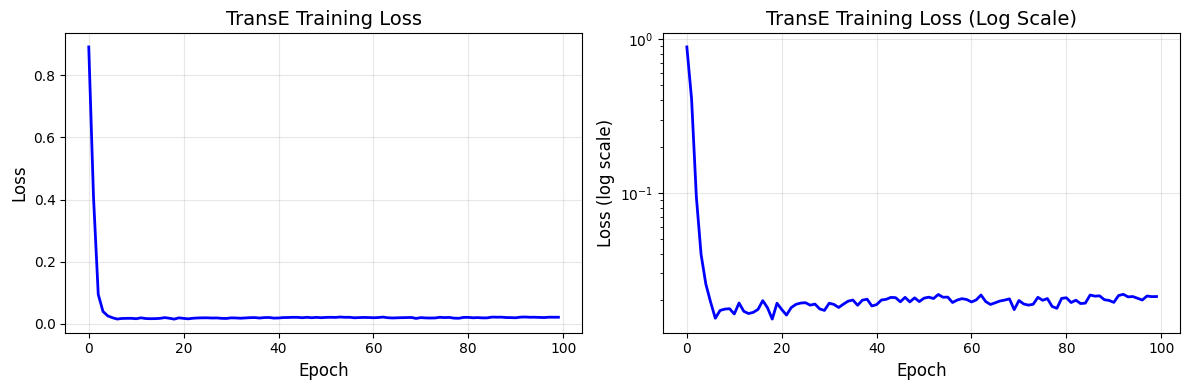


Training Statistics:
  Initial loss: 0.8911
  Final loss: 0.0211
  Reduction: 97.6%
  Min loss: 0.0151 (epoch 19)


In [8]:
# === TRAINING LOSS VISUALIZATION ===

plt.figure(figsize=(12, 4))

# Plot 1: Full loss curve
plt.subplot(1, 2, 1)
plt.plot(loss_history, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('TransE Training Loss', fontsize=14)
plt.grid(True, alpha=0.3)

# Plot 2: Log scale to see convergence better
plt.subplot(1, 2, 2)
plt.plot(loss_history, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('TransE Training Loss (Log Scale)', fontsize=14)
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nTraining Statistics:")
print(f"  Initial loss: {loss_history[0]:.4f}")
print(f"  Final loss: {loss_history[-1]:.4f}")
print(f"  Reduction: {(1 - loss_history[-1]/loss_history[0])*100:.1f}%")
print(f"  Min loss: {min(loss_history):.4f} (epoch {loss_history.index(min(loss_history))+1})")

In [9]:
# === EVALUATION ===

print("\n" + "="*70)
print("STEP 7: EVALUATION")
print("="*70)

def evaluate(model, test_triples, all_triples_set, num_entities, device, 
             verbose=True):
    """
    Evaluate link prediction performance.
    
    For each test triple (h, r, t):
    1. TAIL PREDICTION: Score all (h, r, e) for e in entities, rank true t
    2. HEAD PREDICTION: Score all (e, r, t) for e in entities, rank true h
    
    We use FILTERED ranking: remove other true triples from ranking.
    
    Metrics:
    - MRR: Mean Reciprocal Rank (average of 1/rank)
    - MR: Mean Rank
    - Hits@K: Proportion of true entities in top K
    """
    model.eval()
    
    all_ranks = []
    
    with torch.no_grad():
        for idx in tqdm(range(len(test_triples)), desc="Evaluating", disable=not verbose):
            h, r, t = test_triples[idx].tolist()
            
            # === TAIL PREDICTION: (h, r, ?) ===
            # Score all possible tails
            heads = torch.full((num_entities,), h, dtype=torch.long, device=device)
            rels = torch.full((num_entities,), r, dtype=torch.long, device=device)
            all_tails = torch.arange(num_entities, device=device)
            
            scores_tail = model.score(heads, rels, all_tails)
            
            # Filtered ranking: mask out other true triples
            for candidate_t in range(num_entities):
                if candidate_t != t and (h, r, candidate_t) in all_triples_set:
                    scores_tail[candidate_t] = float('-inf')
            
            # Get rank of true tail (1-indexed)
            sorted_indices = torch.argsort(scores_tail, descending=True)
            rank_tail = (sorted_indices == t).nonzero(as_tuple=True)[0].item() + 1
            
            # === HEAD PREDICTION: (?, r, t) ===
            all_heads = torch.arange(num_entities, device=device)
            tails = torch.full((num_entities,), t, dtype=torch.long, device=device)
            
            scores_head = model.score(all_heads, rels, tails)
            
            # Filtered ranking
            for candidate_h in range(num_entities):
                if candidate_h != h and (candidate_h, r, t) in all_triples_set:
                    scores_head[candidate_h] = float('-inf')
            
            sorted_indices = torch.argsort(scores_head, descending=True)
            rank_head = (sorted_indices == h).nonzero(as_tuple=True)[0].item() + 1
            
            all_ranks.append(rank_tail)
            all_ranks.append(rank_head)
    
    # Compute metrics
    all_ranks = np.array(all_ranks)
    
    metrics = {
        'MRR': np.mean(1.0 / all_ranks),
        'MR': np.mean(all_ranks),
        'Hits@1': np.mean(all_ranks <= 1),
        'Hits@3': np.mean(all_ranks <= 3),
        'Hits@10': np.mean(all_ranks <= 10),
    }
    
    return metrics, all_ranks

print("Evaluation function defined.")
print("""
📊 Metrics explanation:
   - MRR: Mean Reciprocal Rank (1.0 = perfect, higher is better)
   - MR: Mean Rank (1 = perfect, lower is better)
   - Hits@K: % of correct answers in top K (higher is better)
""")


STEP 7: EVALUATION
Evaluation function defined.

📊 Metrics explanation:
   - MRR: Mean Reciprocal Rank (1.0 = perfect, higher is better)
   - MR: Mean Rank (1 = perfect, lower is better)
   - Hits@K: % of correct answers in top K (higher is better)



In [10]:
# === RUN EVALUATION ===

print("\n" + "="*70)
print("EVALUATING TRANSE ON TEST SET")
print("="*70)

print(f"\nTest set: {len(test_triples)} triples")
print(f"Relations being tested: {test_df['relation'].unique().tolist()}")
print()

# Run evaluation
metrics, all_ranks = evaluate(
    model=model,
    test_triples=test_triples,
    all_triples_set=all_triples_set,
    num_entities=num_entities,
    device=device
)

# Print results
print("\n" + "="*50)
print("TRANSE RESULTS")
print("="*50)
print(f"\n{'Metric':<15} {'Value':>10}")
print("-"*25)
print(f"{'MRR':<15} {metrics['MRR']:>10.4f}")
print(f"{'MR':<15} {metrics['MR']:>10.2f}")
print(f"{'Hits@1':<15} {metrics['Hits@1']:>10.4f}")
print(f"{'Hits@3':<15} {metrics['Hits@3']:>10.4f}")
print(f"{'Hits@10':<15} {metrics['Hits@10']:>10.4f}")


EVALUATING TRANSE ON TEST SET

Test set: 590 triples
Relations being tested: ['motherOf', 'fatherOf', 'sonOf', 'daughterOf']



Evaluating: 100%|██████████| 590/590 [00:01<00:00, 583.85it/s]


TRANSE RESULTS

Metric               Value
-------------------------
MRR                 0.2160
MR                    7.62
Hits@1              0.0025
Hits@3              0.2839
Hits@10             0.7483



DETAILED ANALYSIS


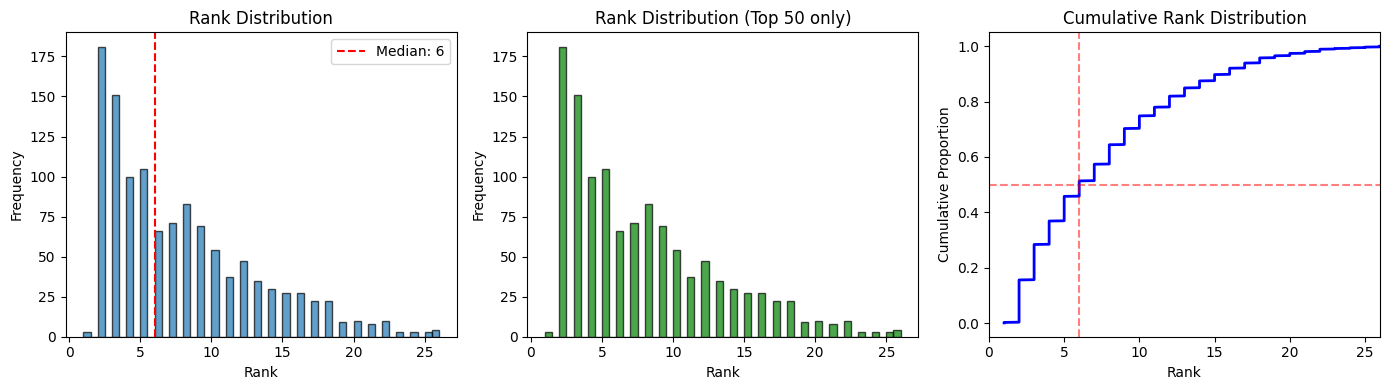


📊 Performance by Relation Type:
------------------------------------------------------------
daughterOf           (n=200): MRR=0.2103, Hits@1=0.0050, Hits@10=0.7325
fatherOf             (n= 88): MRR=0.2445, Hits@1=0.0000, Hits@10=0.7955
motherOf             (n= 88): MRR=0.2192, Hits@1=0.0057, Hits@10=0.7500
sonOf                (n=214): MRR=0.2083, Hits@1=0.0000, Hits@10=0.7430


In [11]:
# === RESULTS ANALYSIS ===

print("\n" + "="*70)
print("DETAILED ANALYSIS")
print("="*70)

# Rank distribution
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.hist(all_ranks, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank Distribution')
plt.axvline(x=np.median(all_ranks), color='r', linestyle='--', label=f'Median: {np.median(all_ranks):.0f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(all_ranks[all_ranks <= 50], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank Distribution (Top 50 only)')

plt.subplot(1, 3, 3)
# Cumulative distribution
sorted_ranks = np.sort(all_ranks)
cumulative = np.arange(1, len(sorted_ranks) + 1) / len(sorted_ranks)
plt.plot(sorted_ranks, cumulative, 'b-', linewidth=2)
plt.xlabel('Rank')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Rank Distribution')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=np.median(all_ranks), color='r', linestyle='--', alpha=0.5)
plt.xlim(0, min(100, max(all_ranks)))

plt.tight_layout()
plt.show()

# Analysis by relation type
print("\n📊 Performance by Relation Type:")
print("-"*60)

test_triples_np = test_triples.numpy()
relation_metrics = {}

for rel_id in sorted(set(test_triples_np[:, 1])):
    rel_name = id2relation[rel_id]
    mask = test_triples_np[:, 1] == rel_id
    rel_count = mask.sum()
    
    # Get ranks for this relation (2 ranks per triple: head and tail)
    rel_indices = np.where(mask)[0]
    rel_ranks = []
    for idx in rel_indices:
        rel_ranks.append(all_ranks[2*idx])      # tail rank
        rel_ranks.append(all_ranks[2*idx + 1])  # head rank
    
    rel_ranks = np.array(rel_ranks)
    
    relation_metrics[rel_name] = {
        'count': rel_count,
        'MRR': np.mean(1.0 / rel_ranks),
        'Hits@1': np.mean(rel_ranks <= 1),
        'Hits@10': np.mean(rel_ranks <= 10)
    }
    
    print(f"{rel_name:<20} (n={rel_count:>3}): MRR={np.mean(1.0/rel_ranks):.4f}, "
          f"Hits@1={np.mean(rel_ranks<=1):.4f}, Hits@10={np.mean(rel_ranks<=10):.4f}")

In [12]:
# === INSIGHTS ===

print("\n" + "="*70)
print("INSIGHTS & CONNECTION TO TASK 3")
print("="*70)

print(f"""
📊 TRANSE PERFORMANCE SUMMARY:
   
   MRR: {metrics['MRR']:.4f}
   Hits@1: {metrics['Hits@1']*100:.1f}%
   Hits@10: {metrics['Hits@10']*100:.1f}%
   Mean Rank: {metrics['MR']:.1f} (out of {num_entities} entities)

🔗 CONNECTION TO TASK 3:

   In Task 3, we discovered:
   - 590 missing parent-child inverse edges
   - Parent-child inverse rules had only 83-86% confidence
   - This was due to INCOMPLETE data
   
   The test set IS exactly those 590 missing edges!
   
💡 TRANSE BEHAVIOR ON INVERSES:
   
   TransE models: h + r ≈ t
   
   For inverse relations (fatherOf ↔ sonOf/daughterOf):
   - If h + r_father ≈ t, then ideally t + r_son ≈ h
   - This requires: r_son ≈ -r_father
   
   TransE CAN learn this, but it's implicit rather than explicit.
   
🤔 EXPECTED IMPROVEMENTS WITH ROTATE:
   
   RotatE models inverses EXPLICITLY:
   - Relations are rotations: h ⊙ r = t
   - Inverse = conjugate rotation: r_inverse = r*
   - This is a more natural fit for our test set!

📈 NEXT STEPS:
   1. Implement RotatE and compare
   2. Analyze which specific triples are hard/easy
   3. Try different hyperparameters
""")

# Save results for later comparison
transe_metrics = metrics.copy()
transe_loss_history = loss_history.copy()
print("\n✓ Results saved for comparison with future models")


INSIGHTS & CONNECTION TO TASK 3

📊 TRANSE PERFORMANCE SUMMARY:
   
   MRR: 0.2160
   Hits@1: 0.3%
   Hits@10: 74.8%
   Mean Rank: 7.6 (out of 1316 entities)

🔗 CONNECTION TO TASK 3:

   In Task 3, we discovered:
   - 590 missing parent-child inverse edges
   - Parent-child inverse rules had only 83-86% confidence
   - This was due to INCOMPLETE data
   
   The test set IS exactly those 590 missing edges!
   
💡 TRANSE BEHAVIOR ON INVERSES:
   
   TransE models: h + r ≈ t
   
   For inverse relations (fatherOf ↔ sonOf/daughterOf):
   - If h + r_father ≈ t, then ideally t + r_son ≈ h
   - This requires: r_son ≈ -r_father
   
   TransE CAN learn this, but it's implicit rather than explicit.
   
🤔 EXPECTED IMPROVEMENTS WITH ROTATE:
   
   RotatE models inverses EXPLICITLY:
   - Relations are rotations: h ⊙ r = t
   - Inverse = conjugate rotation: r_inverse = r*
   - This is a more natural fit for our test set!

📈 NEXT STEPS:
   1. Implement RotatE and compare
   2. Analyze which specific t

In [4]:
import random
import networkx as nx

# Function to load data from the text file
def load_data(file_path):
    heads = []
    relations = []
    tails = []
    entity_map = {}
    entity_counter = 0

    # Read the file
    with open(file_path, 'r') as file:
        for line in file:
            head, relation, tail = line.strip().split()

            # Create an entity-to-index map if not already done
            if head not in entity_map:
                entity_map[head] = entity_counter
                entity_counter += 1
            if tail not in entity_map:
                entity_map[tail] = entity_counter
                entity_counter += 1

            # Append head, relation, tail to respective lists
            heads.append(entity_map[head])
            tails.append(entity_map[tail])
            relations.append(relation)

    # Convert relations into numerical indices (just for visualization)
    relation_map = {rel: idx for idx, rel in enumerate(set(relations))}
    relations_numeric = [relation_map[rel] for rel in relations]

    # Return as a data object (you can modify this part as needed for your code)
    return {
        'num_entities': len(entity_map),
        'train_edge_index': (heads, tails),
        'train_edge_type': relations_numeric
    }

# Function to visualize the graph
def visualize_graph(data, out_path, reduction=200):
    nodes = range(data['num_entities'])
    edges = []
    edge_relations = []

    num_edges = 0
    num_edges_to_process = len(data['train_edge_type'])  # Directly use the length of train_edge_type

    for i in range(num_edges_to_process):
        if random.randint(1, reduction) == 1:  # only take a random subset of edges
            edges.append((data['train_edge_index'][0][i], data['train_edge_index'][1][i]))
            edge_relations.append(data['train_edge_type'][i])
            num_edges += 1

    G = nx.DiGraph()
    G.add_edges_from(edges)
    for i, (head, tail) in enumerate(edges):
        G[head][tail]["relation"] = edge_relations[i]

    nx.write_gexf(G, path=out_path)

# Load data from the given file
file_path = '/kaggle/input/test-txt/test.txt'
data = load_data(file_path)

# Visualize the graph and save the output to a file
visualize_graph(data, 'testing_KG.gexf')


In [5]:
import random
import networkx as nx

# Function to load data from the text file
def load_data(file_path):
    heads = []
    relations = []
    tails = []
    entity_map = {}
    entity_counter = 0

    # Read the file
    with open(file_path, 'r') as file:
        for line in file:
            head, relation, tail = line.strip().split()

            # Create an entity-to-index map if not already done
            if head not in entity_map:
                entity_map[head] = entity_counter
                entity_counter += 1
            if tail not in entity_map:
                entity_map[tail] = entity_counter
                entity_counter += 1

            # Append head, relation, tail to respective lists
            heads.append(entity_map[head])
            tails.append(entity_map[tail])
            relations.append(relation)

    # Convert relations into numerical indices (just for visualization)
    relation_map = {rel: idx for idx, rel in enumerate(set(relations))}
    relations_numeric = [relation_map[rel] for rel in relations]

    # Return as a data object (you can modify this part as needed for your code)
    return {
        'num_entities': len(entity_map),
        'train_edge_index': (heads, tails),
        'train_edge_type': relations_numeric
    }

# Function to visualize the graph
def visualize_graph(data, out_path, reduction=200):
    nodes = range(data['num_entities'])
    edges = []
    edge_relations = []

    num_edges = 0
    num_edges_to_process = len(data['train_edge_type'])  # Directly use the length of train_edge_type

    for i in range(num_edges_to_process):
        if random.randint(1, reduction) == 1:  # only take a random subset of edges
            edges.append((data['train_edge_index'][0][i], data['train_edge_index'][1][i]))
            edge_relations.append(data['train_edge_type'][i])
            num_edges += 1

    G = nx.DiGraph()
    G.add_edges_from(edges)
    for i, (head, tail) in enumerate(edges):
        G[head][tail]["relation"] = edge_relations[i]

    nx.write_gexf(G, path=out_path)

# Load data from the given file
file_path = '/kaggle/input/train-txt/train.txt'
data = load_data(file_path)

# Visualize the graph and save the output to a file
visualize_graph(data, 'training_KG.gexf')


In [6]:
pip install pyvis networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
from pyvis.network import Network
import random
import networkx as nx

# Function to load data from the text file
def load_data(file_path):
    heads = []
    relations = []
    tails = []
    entity_map = {}
    entity_counter = 0

    # Read the file
    with open(file_path, 'r') as file:
        for line in file:
            head, relation, tail = line.strip().split()

            # Create an entity-to-index map if not already done
            if head not in entity_map:
                entity_map[head] = entity_counter
                entity_counter += 1
            if tail not in entity_map:
                entity_map[tail] = entity_counter
                entity_counter += 1

            # Append head, relation, tail to respective lists
            heads.append(entity_map[head])
            tails.append(entity_map[tail])
            relations.append(relation)

    # Convert relations into numerical indices (just for visualization)
    relation_map = {rel: idx for idx, rel in enumerate(set(relations))}
    relations_numeric = [relation_map[rel] for rel in relations]

    # Return as a data object (you can modify this part as needed for your code)
    return {
        'num_entities': len(entity_map),
        'train_edge_index': (heads, tails),
        'train_edge_type': relations_numeric
    }

# Function to visualize with PyVis
def visualize_with_pyvis(data, out_path):
    G = nx.DiGraph()
    edges = [(data['train_edge_index'][0][i], data['train_edge_index'][1][i]) for i in range(len(data['train_edge_type']))]
    edge_relations = data['train_edge_type']
    G.add_edges_from(edges)
    
    for i, (head, tail) in enumerate(edges):
        G[head][tail]["relation"] = edge_relations[i]
    
    # Create a PyVis network object
    # Create a PyVis network object with inline resources
    net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')

    net.from_nx(G)
    
    # Customize the appearance of nodes and edges
    net.force_atlas_2based()  # Use the Force Atlas layout (you can experiment with others)
    
    # Add community coloring (optional) for better visualization
    for node in net.nodes:
        # For example, you can group by community (adjust to your dataset's community mapping)
        node['group'] = random.randint(0, 50)  # Randomly assign a group (you could have a more sophisticated method here)

    net.show(out_path)  # Save and show the HTML file

# Load your data
file_path = '/kaggle/input/test-txt/test.txt'
data = load_data(file_path)

# Visualize and output the interactive graph
visualize_with_pyvis(data, 'family_knowledge_graph.html')


family_knowledge_graph.html


In [10]:
from pyvis.network import Network
import random
import networkx as nx

# Function to load data from the text file
def load_data(file_path):
    heads = []
    relations = []
    tails = []
    entity_map = {}
    entity_counter = 0

    # Read the file
    with open(file_path, 'r') as file:
        for line in file:
            head, relation, tail = line.strip().split()

            # Create an entity-to-index map if not already done
            if head not in entity_map:
                entity_map[head] = entity_counter
                entity_counter += 1
            if tail not in entity_map:
                entity_map[tail] = entity_counter
                entity_counter += 1

            # Append head, relation, tail to respective lists
            heads.append(entity_map[head])
            tails.append(entity_map[tail])
            relations.append(relation)

    # Convert relations into numerical indices (just for visualization)
    relation_map = {rel: idx for idx, rel in enumerate(set(relations))}
    relations_numeric = [relation_map[rel] for rel in relations]

    # Return as a data object (you can modify this part as needed for your code)
    return {
        'num_entities': len(entity_map),
        'train_edge_index': (heads, tails),
        'train_edge_type': relations_numeric
    }

# Function to visualize with PyVis
def visualize_with_pyvis(data, out_path):
    G = nx.DiGraph()
    edges = [(data['train_edge_index'][0][i], data['train_edge_index'][1][i]) for i in range(len(data['train_edge_type']))]
    edge_relations = data['train_edge_type']
    G.add_edges_from(edges)
    
    for i, (head, tail) in enumerate(edges):
        G[head][tail]["relation"] = edge_relations[i]
    
    # Create a PyVis network object
    # Create a PyVis network object with inline resources
    net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')

    net.from_nx(G)
    
    # Customize the appearance of nodes and edges
    net.force_atlas_2based()  # Use the Force Atlas layout (you can experiment with others)
    
    # Add community coloring (optional) for better visualization
    for node in net.nodes:
        # For example, you can group by community (adjust to your dataset's community mapping)
        node['group'] = random.randint(0, 50)  # Randomly assign a group (you could have a more sophisticated method here)

    net.show(out_path)  # Save and show the HTML file

# Load your data
file_path = '/kaggle/input/train-txt/train.txt'
data = load_data(file_path)

# Visualize and output the interactive graph
visualize_with_pyvis(data, 'family_knowledge_graph_training.html')


family_knowledge_graph_training.html
